In [1]:
# If you run on colab uncomment the following line
#!pip install git+https://github.com/clementchadebec/benchmark_VAE.git

In [2]:
import torch
import torchvision.datasets as datasets

%load_ext autoreload
%autoreload 2

In [3]:
mnist_trainset = datasets.MNIST(root='../../data', train=True, download=True, transform=None)

train_dataset = mnist_trainset.data[:-50000].reshape(-1, 1, 28, 28) / 255.
eval_dataset = mnist_trainset.data[-10000:].reshape(-1, 1, 28, 28) / 255.

/home/clement/anaconda3/envs/pythae/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
from pythae.models import VQVAE, VQVAEConfig
from pythae.trainers import BaseTrainingConfig
from pythae.pipelines.training import TrainingPipeline
from pythae.models.nn.benchmarks.mnist import Encoder_AE_MNIST, Decoder_AE_MNIST

In [6]:
config = BaseTrainingConfig(
    output_dir='my_model',
    learning_rate=1e-3,
    batch_size=100,
    num_epochs=100,
)


model_config = VQVAEConfig(
    latent_dim=16,
    input_dim=(1, 28, 28),
    beta=0.25,
    quantization_loss_factor=0.2,
    num_embeddings=128
)

model = VQVAE(
    model_config=model_config,
    encoder=Encoder_AE_MNIST(model_config), 
    decoder=Decoder_AE_MNIST(model_config) 
)

In [7]:
pipeline = TrainingPipeline(
    training_config=config,
    model=model
)

In [8]:
pipeline(
    train_data=train_dataset,
    eval_data=eval_dataset
)

Preprocessing train data...
Preprocessing eval data...

Using Base Trainer

Model passed sanity check !

Created my_model/VQVAE_training_2022-03-02_14-35-13. 
Training config, checkpoints and final model will be saved here.

Successfully launched training !

Eval of epoch 1/1: 100%|██████████| 100/100 [00:04<00:00, 21.72batch/s]
----------------------------------------------------------------
Epoch 1: Train loss: 306.9520608521
Epoch 1: Eval loss: 527.1457736206
----------------------------------------------------------------
----------------------------------
Training ended!
Saved final model in my_model/VQVAE_training_2022-03-02_14-35-13/final_model


In [9]:
import os

In [10]:
last_training = sorted(os.listdir('my_model'))[-1]
trained_model = VQVAE.load_from_folder(os.path.join('my_model', last_training, 'final_model'))

In [11]:
recon = trained_model({'data': eval_dataset[:50]}).recon_x.detach().cpu()

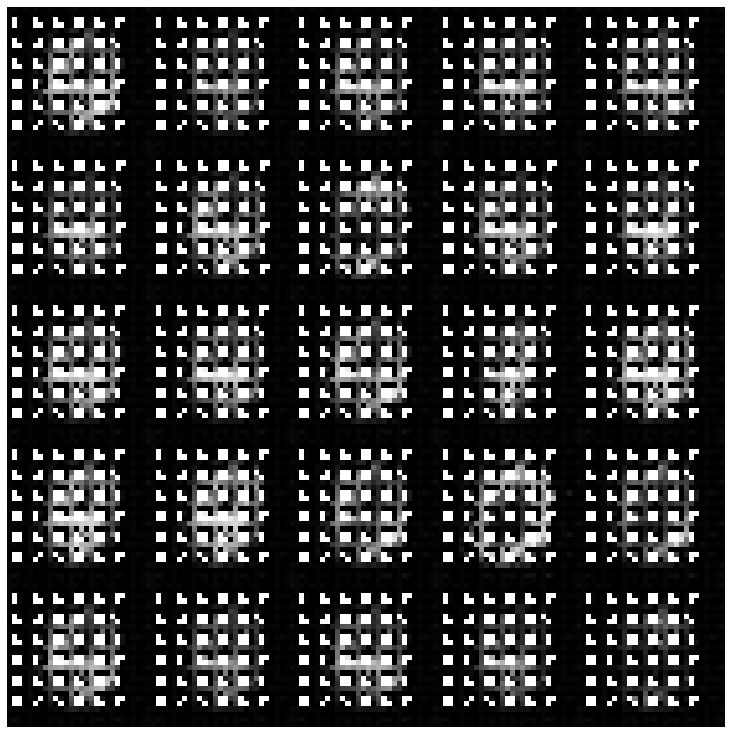

In [12]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        axes[i][j].imshow(recon[i*5 +j].cpu().squeeze(0), cmap='gray')
        axes[i][j].axis('off')
plt.tight_layout(pad=0.)

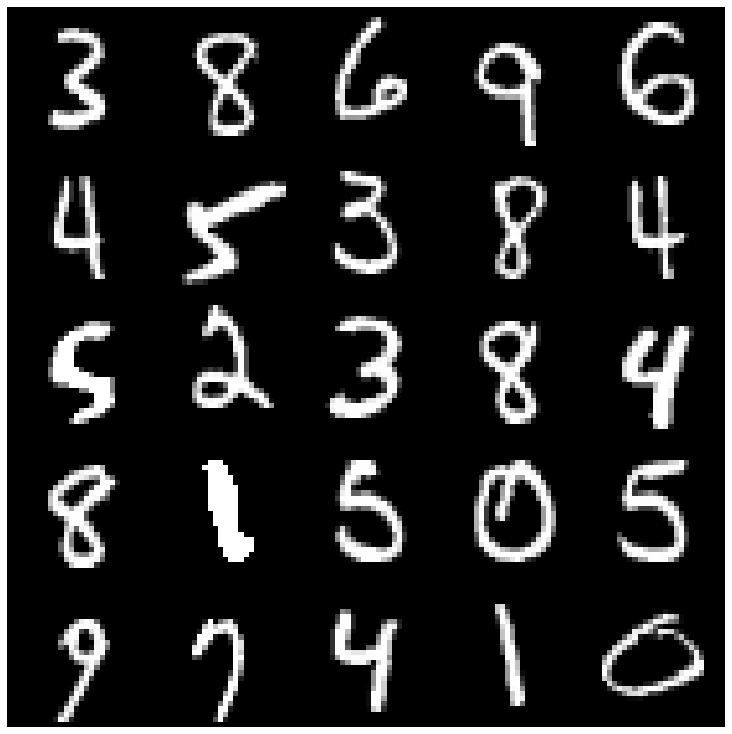

In [13]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        axes[i][j].imshow(eval_dataset[i*5 +j].cpu().squeeze(0), cmap='gray')
        axes[i][j].axis('off')
plt.tight_layout(pad=0.)